# Moving Average Crossover

This notebook describes a Rolling Average Crossover algorithm, whereby buy signals (to go long) are generated when a short window moving average increases beyond a long window moving average for a period greater than or equal to the short moving average window size, and sell signals (to go short) are generated in the same way when the short window moving average decreases below the long window moving average.

## Imports

In [29]:
# Utils
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data
import pandas_datareader as pdr

## Data acquisition

In [99]:
# Import AAPL data (switch out here to see algorithm against other stocks e.g. GOOG, AMZN, MSFT, etc.)
df_aapl = pdr.get_data_yahoo('AAPL', start=dt.datetime(2010, 1, 1), end=dt.datetime(2020, 1, 1))

df_aapl.tail()

High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2019-12-24  71.222504  70.730003  71.172501  71.067497   48478800.0  70.580566
2019-12-26  72.495003  71.175003  71.205002  72.477501   93121200.0  71.980911
2019-12-27  73.492500  72.029999  72.779999  72.449997  146266000.0  71.953598
2019-12-30  73.172501  71.305000  72.364998  72.879997  144114400.0  72.380653
2019-12-31  73.419998  72.379997  72.482498  73.412498  100805600.0  72.909500

## Algorithm

In [100]:
# Define lookback windows (days)
SHORT_WIN = 40
LONG_WIN = 100

# Create dataframe for buy/sell signals
df_signals = pd.DataFrame(index=df_aapl.index)  # Use df_aapl index for ease manipulating later (index is Date)
df_signals['signal'] = 0.0

# Calculate moving average windows
df_signals[str(SHORT_WIN) + '_mv_avg'] = df_aapl['Adj Close'].rolling(window=SHORT_WIN).mean()
df_signals[str(LONG_WIN) + '_mv_avg'] = df_aapl['Adj Close'].rolling(window=LONG_WIN).mean()

# Create signals
df_signals['signal'][SHORT_WIN:] = np.where(df_signals[str(SHORT_WIN) + '_mv_avg'][SHORT_WIN:] > df_signals[str(LONG_WIN) + '_mv_avg'][SHORT_WIN:], 1.0, 0.0)

# Generate trading orders
df_signals['position'] = df_signals['signal'].diff()

In [101]:
df_signals.tail()#50)

signal  40_mv_avg  100_mv_avg  position
Date                                               
2019-12-24     1.0  65.936380   58.876569       0.0
2019-12-26     1.0  66.230279   59.119589       0.0
2019-12-27     1.0  66.523681   59.353309       0.0
2019-12-30     1.0  66.793722   59.586269       0.0
2019-12-31     1.0  67.033292   59.813692       0.0

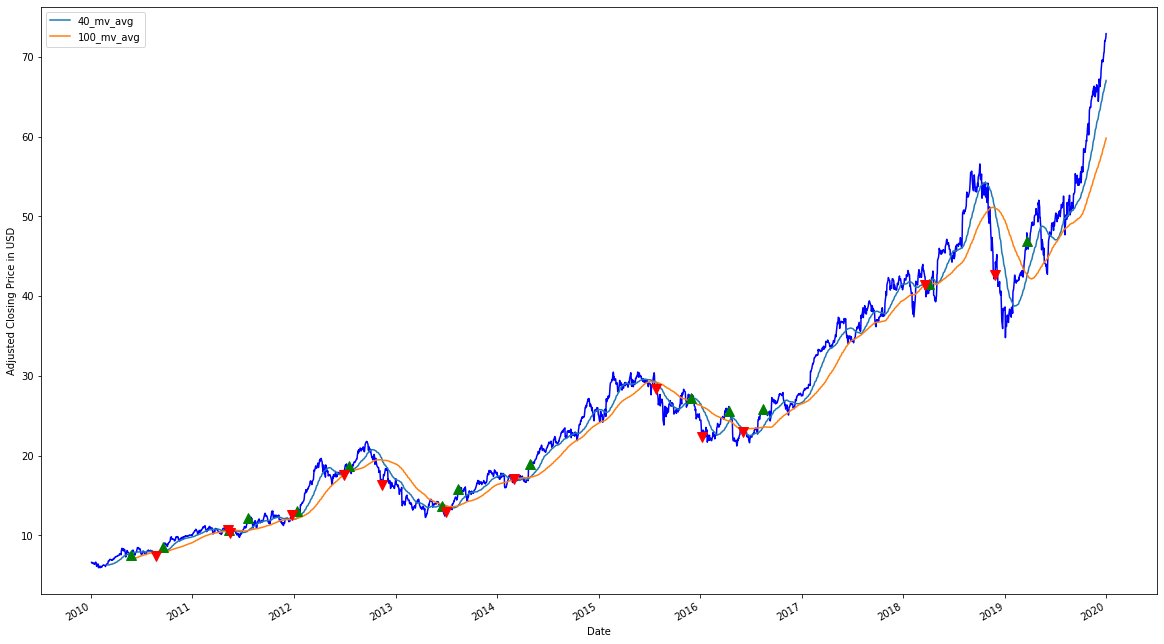

In [102]:
fig = plt.figure(figsize=(20, 12))

# Add a subplot and label for y-axis
ax = fig.add_subplot(ylabel='Adjusted Closing Price in USD')

# Plot the closing price
df_aapl['Adj Close'].plot(ax=ax, color='b')

# Plot the short and long moving averages
df_signals[[str(SHORT_WIN) + '_mv_avg', str(LONG_WIN) + '_mv_avg']].plot(ax=ax)

# Plot the buy signals
ax.plot(
        df_signals.loc[df_signals['position'] == 1.0].index,
        df_aapl['Adj Close'][df_signals['position'] == 1.0], 
        '^',
        markersize=10,
        color='g'
    )
         
# Plot the sell signals
ax.plot(
        df_signals.loc[df_signals['position'] == -1.0].index,
        df_aapl['Adj Close'][df_signals['position'] == -1.0],
        'v',
        markersize=10,
        color='r'
    )

# Show the plot
plt.show()

## Backtesting

In [103]:
# Define initial capital investment and shares to buy on buy signal
INITIAL_CAPITAL = 100000.0
BUY_SELL_SHARES_NO = 100

In [104]:
# Dataframe to hold share positions (number of shares owned over time)
df_positions = pd.DataFrame(index=df_signals.index).fillna(0.0)
df_positions['aapl'] = BUY_SELL_SHARES_NO * df_signals['signal']  # Will buy or sell BUY_SELL_SHARES_NO each time the signal is 1/-1

# Dataframe to hold value of portfolio
df_portfolio = df_positions.multiply(df_aapl['Adj Close'], axis=0)

# Dataframe to store the difference in shares owned 
df_pos_diff = df_positions.diff()

In [105]:
# Add holdings column to portfolio (value of shares held)
df_portfolio['holdings'] = (df_positions.multiply(df_aapl['Adj Close'], axis=0)).sum(axis=1)

# Add cash column (initial investment minus cash used to buy shares)
df_portfolio['cash'] = INITIAL_CAPITAL - (df_pos_diff.multiply(df_aapl['Adj Close'], axis=0)).sum(axis=1).cumsum()

# Add total column (value of overall portfolio in cash and shares held)
df_portfolio['total'] = df_portfolio['cash'] + df_portfolio['holdings']

# Add returns column (percentage change)
df_portfolio['returns'] = df_portfolio['total'].pct_change()

df_portfolio

aapl     holdings          cash          total   returns
Date                                                                       
2010-01-04     0.000000     0.000000  100000.00000  100000.000000       NaN
2010-01-05     0.000000     0.000000  100000.00000  100000.000000  0.000000
2010-01-06     0.000000     0.000000  100000.00000  100000.000000  0.000000
2010-01-07     0.000000     0.000000  100000.00000  100000.000000  0.000000
2010-01-08     0.000000     0.000000  100000.00000  100000.000000  0.000000
...                 ...          ...           ...            ...       ...
2019-12-24  7058.056641  7058.056641   97641.24155  104699.298191  0.000064
2019-12-26  7198.091125  7198.091125   97641.24155  104839.332676  0.001337
2019-12-27  7195.359802  7195.359802   97641.24155  104836.601353 -0.000026
2019-12-30  7238.065338  7238.065338   97641.24155  104879.306889  0.000407
2019-12-31  7290.950012  7290.950012   97641.24155  104932.191563  0.000504

[2516 rows x 5 columns]

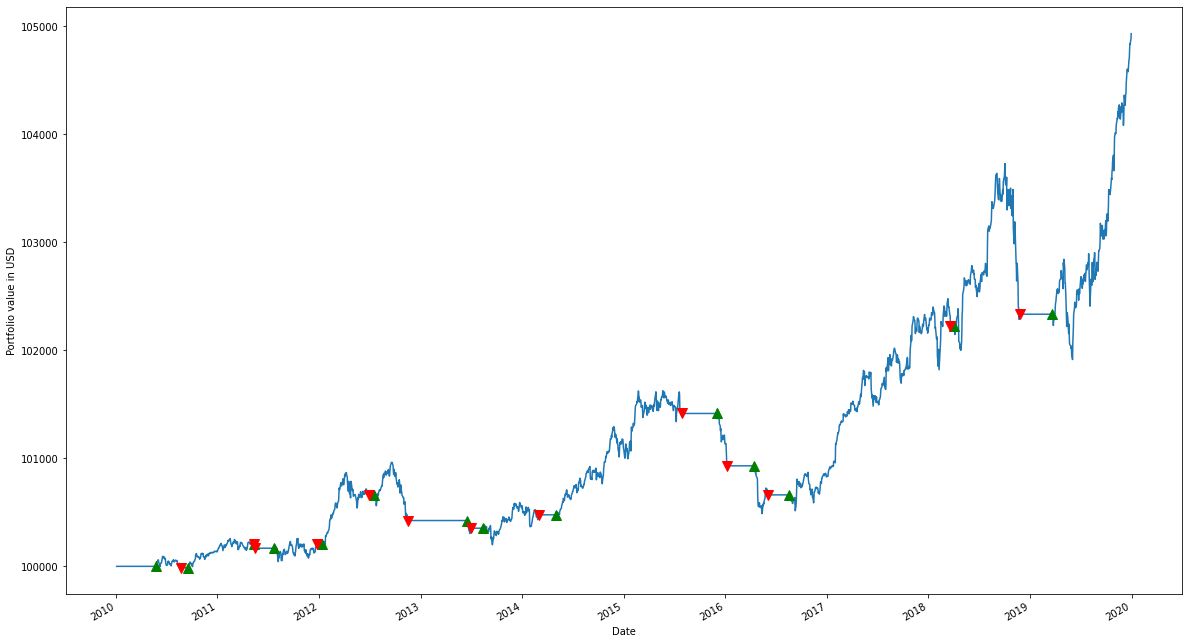

In [106]:
fig = plt.figure(figsize=(20, 12))

# Add a subplot and label for y-axis
ax = fig.add_subplot(ylabel='Portfolio value in USD')

# Plot the equity curve
df_portfolio['total'].plot(ax=ax)

# Plot the buy signals
ax.plot(
        df_portfolio.loc[df_signals['position'] == 1.0].index, 
        df_portfolio['total'][df_signals['position'] == 1.0],
         '^',
        markersize=10,
        color='g'
    )

# Plot the sell signals
ax.plot(
        df_portfolio.loc[df_signals['position'] == -1.0].index, 
        df_portfolio['total'][df_signals['position'] == -1.0],
        'v',
        markersize=10,
        color='r'
    )

# Show the plot
plt.show()